# 멋진 챗봇 만들기

이번프로젝트에서는 한국어데이터로  챗봇을 구현해보겠다. [Ex 12노드](https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp12/Exp12_Assignment_KoreanChatbot.ipynb)에서 진행했던 Task와 같은 주제이지만 토큰화 방식과 훈련 방법이 다를때 결과를 비교해볼수 있을것 같다.
- 데이터셋 구성
 - Mecab 토크나이저 이용
 - Data Augmentation : Lexical Substitution(어휘대체)
- 성능 측정 : Blue Score 

한국어 챗봇 데이터는 송영숙님이 공개한 [데이터](https://github.com/songys/Chatbot_data)를 사용했다.


In [1]:
! pip install nltk
! pip install gensim

In [2]:
!pip install konlpy
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     |████████████████████████████████| 19.4 MB 6.8 MB/s 
     |████████████████████████████████| 448 kB 65.7 MB/s 
Installing automake (A dependency for mecab-ko)
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/u

In [3]:
import numpy as np
import pandas as pd
import nltk
import gensim
import urllib.request
import matplotlib.pyplot as plt
import os
import re
import tensorflow as tf

from konlpy.tag import Mecab
from collections import Counter

print(np.__version__)
print(pd.__version__)
print(tf.__version__)
print(nltk.__version__)
print(gensim.__version__)

1.21.5
1.3.5
2.8.0
3.2.5
3.6.0



## Step 1. 데이터 다운로드



 - [ChatBotData.csv](https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv) : 챗봇 트레이닝용 문답 페어 11,876개
 -  다음카페 "사랑보다 아름다운 실연( http://cafe116.daum.net/_c21_/home?grpid=1bld )"에서 자주 나오는 이야기들을 참고하여 제작하였다고함.
 - 연애나 일상이야기위주로 데이터셋이 구성된것을 확인할 수 있다.  
  - 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링
 

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')

train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


### EDA

In [5]:
print('챗봇 데이터 샘플의 개수 :', len(train_data))
print('결측값이 있는 샘플값의 갯수:', train_data.isnull().sum().sum())

챗봇 데이터 샘플의 개수 : 11823
결측값이 있는 샘플값의 갯수: 0


결측치는 없이 질문,답변 pair로 11,823여건이 존재한다.  중복데이터를 확인해보자

In [6]:
train_data[train_data.duplicated(['Q'])]

,Q,A,label
196,고양이 키우고 싶어,가족들과 상의해보세요.,0
235,공시 준비 힘들어,잘 될 거예요.,0
1294,돈 벌고 싶어,많이 벌수록 좋아요.,0
1445,로또 번호 알려줘,알면 제가 하죠.,0
1481,마음이 울적해,거리를 걸어보세요.,0
...,...,...,...
11642,착해서 잘해주는 건지 좋아하는 건지,헷갈린다고 말해보세요.,2
11649,첫 눈에 반하는게 가능해?,당연히 가능하죠.,2
11658,첫사랑 생각나,지금의 사랑에 충실하세요.,2
11732,커플여행이 나을까 그냥 우리끼리 갈까?,저는 둘이 가는 게 좋아요.,2


In [7]:
train_data[train_data.duplicated(['A'])]

,Q,A,label
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0
12,가끔 뭐하는지 궁금해,그 사람도 그럴 거예요.,0
18,가스불 켜놓고 나온거 같아,빨리 집에 돌아가서 끄고 나오세요.,0
...,...,...,...
11806,혼자만 설레고 혼자서 끝내는 짝사랑 그만할래.,맘고생 많았어요.,2
11807,화이트데이에 고백할까요?,선물을 주면서 솔직하고 당당하게 고백해보세요.,2
11809,확실히 날 좋아하는 걸 아는 남자랑 친구가 될 수 있을까?,그 사람을 위해서는 그러면 안돼요.,2
11816,회식하는데 나만 챙겨줘. 썸임?,호감이 있을 수도 있어요. 그렇지만 조금 더 상황을 지켜보세요.,2


In [8]:
train_data[train_data['Q']=='고양이 키우고 싶어']

,Q,A,label
195,고양이 키우고 싶어,자신을 먼저 키우세요.,0
196,고양이 키우고 싶어,가족들과 상의해보세요.,0


In [9]:
train_data[train_data['A']=='맘고생 많았어요.']

,Q,A,label
5751,끝이났네,맘고생 많았어요.,1
6010,니가 원망스러워,맘고생 많았어요.,1
6455,방금 헤어지고 왔습니다,맘고생 많았어요.,1
7726,이제는 정말 끝,맘고생 많았어요.,1
8015,정리가 되네,맘고생 많았어요.,1
8211,진짜 끝,맘고생 많았어요.,1
8221,진짜 이제 안녕,맘고생 많았어요.,1
8234,질질 끄는연애 드디어끝이네.,맘고생 많았어요.,1
10303,썸남이 짝남 됐어요. 위로해 주세요.,맘고생 많았어요.,2
11806,혼자만 설레고 혼자서 끝내는 짝사랑 그만할래.,맘고생 많았어요.,2


위처럼 질문 컬럼에 161건, 답변 컬럼에는 4044건이 중복되어 존재한다. 중복된 답변데이터가 많은데, 비슷한 류의 질문에 대해 같은 답을 반복하여 데이터셋을 설정한것 같다. 답변의 중복 데이터 삭제시 데이터셋이 너무 줄어들어 학습이 어려울수 있어, 질문 데이터에 대해서만 중복삭제처리를 진행하겠다.

- 문장의 단어 개수 확인
 - 코퍼스 구성시 포함할 적절한 단어 개수를 확인해보도록하겠다.


In [10]:
tokenizer = Mecab()

questions = []
answers = []

for sentence in train_data['Q']:
    sen_tok = tokenizer.morphs(sentence) # 토큰화
    questions.append(sen_tok)

for sentence in train_data['A']:
    sen_tok = tokenizer.morphs(sentence) # 토큰화
    answers.append(sen_tok)

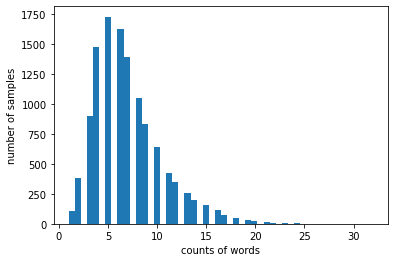

In [11]:
plt.hist([len(s) for s in questions], bins=50)
plt.xlabel('counts of words')
plt.ylabel('number of samples')
plt.show()

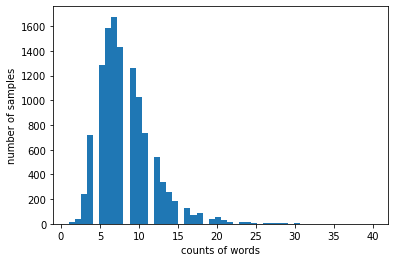

In [12]:
plt.hist([len(s) for s in answers], bins=50)
plt.xlabel('counts of words')
plt.ylabel('number of samples')
plt.show()

문장을 구성하는 단어 길이는 25(max_len)개로 제한하도록 하겠다.

## Step 2. 데이터 정제

1. 영문자의 경우, 모두 소문자로 변환
2. 영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 정규식을 활용하여 모두 제거


In [13]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 단어와 구두점(punctuation - 문장부호 4개) 사이의 거리를 만듭니다.
    sentence = sentence.lower()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-zA-Z가-힣0-9?.!,]+", " ", sentence) 
    sentence = sentence.strip()
    
    return sentence

## Step 3. 데이터 토큰화

데이터 토큰화 요구조건
```
토큰화에는 KoNLPy의 mecab 클래스를 사용합니다.

아래 조건을 만족하는 build_corpus() 함수를 구현하세요!

1. 소스 문장 데이터와 타겟 문장 데이터를 입력으로 받습니다.
2. 데이터를 앞서 정의한 preprocess_sentence() 함수로 정제하고, 토큰화합니다.
3. 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.
4. 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.
5. 중복되는 문장은 데이터에서 제외합니다. 소스 : 타겟 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!

구현한 함수를 활용하여 questions 와 answers 를 각각 que_corpus , ans_corpus 에 토큰화하여 저장합니다.
```

In [14]:
def build_corpus(train_data, tokenizer, max_len) :
    print('total data:', train_data.shape)

    # 데이터의 중복 제거
    train_data.drop_duplicates(subset=['Q'], inplace=True)
    #train_data.drop_duplicates(subset=['A'], inplace=True)

    print('drop duplicates:', train_data.shape)

    #데이터 정제
    train_data['Q'] = list(map(preprocess_sentence, train_data['Q']))
    train_data['A'] = list(map(preprocess_sentence, train_data['A']))

    # 한국어 토크나이저로 토큰화
    que_corpus = []
    ans_corpus = []
    for (sentence1, sentence2) in zip(train_data['Q'], train_data['A']):
        if len(sentence1) <= max_len and len(sentence2) <= max_len:
            sen_tok = tokenizer.morphs(sentence1) # 토큰화
            que_corpus.append(sen_tok)

            sen_tok = tokenizer.morphs(sentence2) # 토큰화
            ans_corpus.append(sen_tok)

    print('last corpus size:', len(que_corpus))
    return que_corpus, ans_corpus

max_len = 25
que_corpus, ans_corpus = build_corpus(train_data, tokenizer, max_len) 

total data: (11823, 3)
drop duplicates: (11662, 3)
last corpus size: 10240


전체 데이터셋 11823건중 중복을 제거한 경우 11662여건이 남았고, 긴문장(단어갯수가 많은경우)을 제외하여 10240건이 최종적으로 남았다. 학습을 하기에 부족한 데이터셋이므로 augmentation작업으로 보충해보자.

## Step 4. Augmentation
Augmentation 요구사항
```
Lexical Substitution을 실제로 적용해 보도록 하겠습니다.

아래 링크를 참고하여 한국어로 사전 훈련된 Embedding 모델을 다운로드합니다. 
Korean (w) 가 Word2Vec으로 학습한 모델이며 용량도 적당하므로 사이트에서 Korean (w)를 찾아 다운로드하고, ko.bin 파일을 얻으세요!

- Kyubyong/wordvectors :https://github.com/Kyubyong/wordvectors

다운로드한 모델을 활용해 데이터를 Augmentation 하세요! 앞서 정의한 lexical_sub() 함수를 참고하면 도움이 많이 될 겁니다.

1. Augmentation된 que_corpus 와 원본 ans_corpus 가 병렬을 이루도록 구성
2. 반대로 원본 que_corpus 와 Augmentation된 ans_corpus 가 병렬을 이루도록 구성
3. 원본 que_corpus, 원본 ans_corpus까지 병합하여 전체 데이터가 원래의 3배가량으로 늘어나도록 합니다.
```

- 본 프로젝트에서는 Lexical Substitution(어휘대체)방법 중 임베딩을 활용한 어휘를 대체하는 방식을 사용하도록하겠다.
- 사전 훈련된 한국어 임베딩 모델
 - [Pre-trained word vectors of 30+ languages](https://github.com/Kyubyong/wordvectors)
 - 위 사이트에서 word2vec와 fastText 타입의 임베딩벡터가 공개되어있다. 한국어 word2vec를 본 프로젝트에서는 이용하도록 하겠다.
 - Korean(w) size: 76.8M

In [15]:
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/Aiffel/03_GoingDeeper/12/ko.zip' -d '/content/wordvec'

In [16]:
word2vec = gensim.models.Word2Vec.load('/content/wordvec/ko.bin')   
word2vec.most_similar('행복')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('사랑', 0.6759077310562134),
 ('기쁨', 0.6493781805038452),
 ('즐거움', 0.6396492719650269),
 ('삶', 0.6299898028373718),
 ('젊음', 0.6187379360198975),
 ('즐겁', 0.6027448177337646),
 ('인생', 0.6002243161201477),
 ('존엄', 0.5952589511871338),
 ('고독', 0.5938762426376343),
 ('불행', 0.5894461870193481)]

사전훈련된 한국어 임베딩 모델을 로드하여 유사단어를 살펴보았다. 이제 lexical_sub 함수를 정의한 후 질문, 답변 코퍼스 데이터를 늘려보겠다.

In [17]:
import random
# Lexical Substitution 구현하기
def lexical_sub(sentence, word2vec, seed, bCheck=False):    

    try:
        random.seed(seed)
        _from = random.choice(sentence)
        _to = word2vec.wv.most_similar(_from)[0][0]
        if bCheck:
            print('selected tok:', _from)
            print('most similar tok : ', _to )

    except:   # 단어장에 없는 단어
        if bCheck:
            print('no tok in word2vec:', _from)

        return None

    #문장 구성
    res = []
    for tok in sentence:
        if tok is _from:
            res.append(_to)
            #res += _to + " "
        else: 
            res.append(tok)
            #res += tok + " "

    return res

In [18]:
lexical_sub(['아이', '는', '바나나', '를', '맛있게', '먹었다','.'], word2vec, 13, bCheck=True)

selected tok: 바나나
most similar tok :  코코넛


['아이', '는', '코코넛', '를', '맛있게', '먹었다', '.']

In [19]:
lexical_sub(['아이', '는', '바나나', '를', '맛있게', '먹었다','.'], word2vec, 100, bCheck=True)

selected tok: 는
most similar tok :  ㄴ다는


['아이', 'ㄴ다는', '바나나', '를', '맛있게', '먹었다', '.']

유사도가 높은 다른 단어로 잘 대체되는 것을 확인할 수 있다.

In [20]:
from tqdm.notebook import tqdm

seed = 13
aug_que_corpus = []
aug_ans_corpus = []

# que_corpus augmentation
for old_src in tqdm(que_corpus):
    new_src = lexical_sub(old_src, word2vec, seed)
    if new_src is not None: 
        aug_que_corpus.append(new_src)
    else:
        # Augmentation이 없을 경우 원본 문장을 포함시킵니다
        aug_que_corpus.append(old_src)   

# ans_corpus augmentation
for old_src in tqdm(ans_corpus):
    new_src = lexical_sub(old_src, word2vec, seed)
    if new_src is not None: 
        aug_ans_corpus.append(new_src)
    else:
        aug_ans_corpus.append(old_src)

  0%|          | 0/10240 [00:00<?, ?it/s]

  0%|          | 0/10240 [00:00<?, ?it/s]

In [21]:
print(que_corpus[5:10])
print(aug_que_corpus[5:10])

[['sd', '카드', '망가졌', '어'], ['sd', '카드', '안', '돼'], ['sns', '맞', '팔', '왜', '안', '하', '지'], ['sns', '시간', '낭비', '인', '거', '아', '는데', '매일', '하', '는', '중'], ['sns', '시간', '낭비', '인데', '자꾸', '보', '게', '됨']]
[['sd', '카드', '망가졌', '어'], ['sd', '카드', '못가', '돼'], ['sns', '맞', '나르', '왜', '안', '하', '지'], ['sns', '시간', '낭비', '인', '것', '아', '는데', '매일', '하', '는', '중'], ['sns', '시간', '낭비', '인데', '그럼', '보', '게', '됨']]


In [22]:
print(ans_corpus[5:10])
print(aug_ans_corpus[5:10])

[['다시', '새로', '사', '는', '게', '마음', '편해요', '.'], ['다시', '새로', '사', '는', '게', '마음', '편해요', '.'], ['잘', '모르', '고', '있', '을', '수', '도', '있', '어요', '.'], ['시간', '을', '정하', '고', '해', '보', '세요', '.'], ['시간', '을', '정하', '고', '해', '보', '세요', '.']]
[['다시', '새로', '사', '는', '도록', '마음', '편해요', '.'], ['다시', '새로', '사', '는', '도록', '마음', '편해요', '.'], ['잘', '모르', '고', '있', '를', '수', '도', '있', '어요', '.'], ['시간', '을', '정하', '고', '해의', '보', '세요', '.'], ['시간', '을', '정하', '고', '해의', '보', '세요', '.']]


증강된 데이터를 병합하여 훈련데이터셋을 설정하겠다. 병합 순서는 프로젝트 요구사항에 명시된 순이다.

In [23]:
que_data = aug_que_corpus + que_corpus + que_corpus
ans_data = ans_corpus + aug_ans_corpus + ans_corpus
len(que_data), len(ans_data)

(30720, 30720)

## Step 5. 데이터 벡터화
```
타겟 데이터인 ans_corpus 에 <start> 토큰과 <end> 토큰이 추가되지 않은 상태이니 이를 먼저 해결한 후 벡터화를 진행합니다. 
우리가 구축한 ans_corpus 는 list 형태이기 때문에 아주 쉽게 이를 해결할 수 있답니다!

1. 타겟 데이터(ans_corpus) 전체에 <start> 토큰과 <end> 토큰을 추가해 주세요!
2. que_corpus 와 결합하여 전체 데이터에 대한 단어 사전을 구축하고 벡터화하여 enc_train 과 dec_train 을 얻으세요!
```

In [24]:
ans_data[:2]

[['하루', '가', '또', '가', '네요', '.'], ['위로', '해', '드립니다', '.']]

In [25]:
for i, data in enumerate(ans_data):
    data = ['<start>'] + data + ['<end>']
    ans_data[i] = data

In [26]:
ans_data[:2]

[['<start>', '하루', '가', '또', '가', '네요', '.', '<end>'],
 ['<start>', '위로', '해', '드립니다', '.', '<end>']]

In [27]:
from collections import Counter

num_words = 7000 #단어사전 크기 

# 사전 word_to_index 구성
words = np.concatenate(que_data).tolist() #[['12', '시가', '땡', '!'], ['1', '중퇴', '학교', '떨어졌', '어']] -> ['12', '시가', '땡', '!', '1', '중퇴', '학교', '떨어졌', '어', '3']
words2 = np.concatenate(ans_data).tolist()
counter = Counter(words + words2)
counter = counter.most_common(num_words-2)  #사용빈도수가 높은 최상위 1만개단어 - 2개는 특수토큰 (start, end 토큰은 ans_data에 반영이되있으므로 제외)
vocab = ['<PAD>', '<UNK>'] + [key for key, _ in counter] #특수토큰
word_to_index = {word:index for index, word in enumerate(vocab)}

# 텍스트 스트링(리뷰문장)을 word_to_index을 참고하여 인덱스 리스트로 구성
def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
enc_train = list(map(wordlist_to_indexlist, que_data))
dec_train = list(map(wordlist_to_indexlist, ans_data))

# 전처리
max_len = 30
enc_train = tf.keras.preprocessing.sequence.pad_sequences(enc_train, padding='post', maxlen=max_len)
dec_train = tf.keras.preprocessing.sequence.pad_sequences(dec_train, padding='post', maxlen=max_len)
enc_train.shape, dec_train.shape

((30720, 30), (30720, 30))

In [28]:
counter[:5]

[('.', 34938), ('<start>', 30720), ('<end>', 30720), ('이', 11621), ('하', 9992)]

In [29]:
enc_train[:2]

array([[2251,  177, 4502,   74,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [ 277, 4356, 4611, 1120,   11,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]], dtype=int32)

In [30]:
dec_train[:2]

array([[   3,  292,    9,  139,    9,   33,    2,    4,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [   3,  544,   16, 1492,    2,    4,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]], dtype=int32)

각 문장이 벡터화된것을 확인하였다. 벡터화된 문장을 디코드해서 확인해보자.

In [31]:
index_to_word = {index:word for word, index in word_to_index.items()}

#텍스트 분석을 위한 인코더, 디코더 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[0:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [32]:
decoded_sentence = get_decoded_sentence( [   3,  292,    9,  139,    9,   33,    2,    4,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0], index_to_word)
decoded_sentence  

'<start> 하루 가 또 가 네요 . <end> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

## Step 6. 훈련하기

```
데이터의 크기가 작으니 하이퍼파라미터를 튜닝해야 과적합을 피할 수 있습니다. 
모델을 훈련하고 아래 예문에 대한 답변을 생성하세요! 
가장 멋진 답변과 모델의 하이퍼파라미터를 제출하시면 됩니다.

# 예문
1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

---

# 제출

Translations
> 1. 잠깐 쉬 어도 돼요 . <end>
> 2. 맛난 거 드세요 . <end>
> 3. 떨리 겠 죠 . <end>
> 4. 좋 아 하 면 그럴 수 있 어요 . <end>

Hyperparameters
> n_layers: 1
> d_model: 368
> n_heads: 8
> d_ff: 1024
> dropout: 0.2

Training Parameters
> Warmup Steps: 1000
> Batch Size: 64
> Epoch At: 10

```

###트랜스포머 모듈 구현 
 - 참고 : [Going Deeper 10 node](https://github.com/riverlike/Aiffel_Project/blob/main/GoingDeeper/nlp10/NLP10_Assinment_Translation2_final.ipynb)


In [33]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)        

        """
        Scaled QK 값 구하기
        """
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9) 

        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))


        return combined_x
    

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

# DecoderLayer 클래스를 작성하세요.
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### 모델 학습

In [34]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

src_vocab_size = len(word_to_index)
tgt_vocab_size = len(word_to_index)

print ('SRC_VOCAB_SIZE :', src_vocab_size)
print ('TGT_VOCAB_SIZE :', tgt_vocab_size)

# Hyperparameters
D_MODEL = 368#256
NUM_LAYERS = 1#2
NUM_HEADS = 8#4
DFF = 1024#512
DROPOUT = 0.2#0.1
POS_LEN = 30

#Training Parameters
BATCH_SIZE = 64
EPOCHS = 10
WARMUP_STAPS = 1000

transformer = Transformer(
    n_layers=NUM_LAYERS,
    d_model=D_MODEL,
    n_heads=NUM_HEADS,
    d_ff=DFF,
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    pos_len=POS_LEN,
    dropout=DROPOUT)

learning_rate = LearningRateScheduler(D_MODEL, WARMUP_STAPS)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

SRC_VOCAB_SIZE : 7000
TGT_VOCAB_SIZE : 7000


In [35]:
for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE)) 
    random.shuffle(idx_list)
    t_bar = tqdm(idx_list)

    for (batch, idx) in enumerate(t_bar):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t_bar.set_description_str('Epoch %2d' % (epoch + 1))
        t_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        t_bar.update()

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

### 테스트

In [37]:
# 번역 생성 함수
def evaluate(sentence, model, tokenizer, word_to_index, index_to_word, max_len):
    sentence = preprocess_sentence(sentence)
    sen_tok = tokenizer.morphs(sentence)
    sen_enc = get_encoded_sentence(sentence, word_to_index)

    _input = tf.keras.preprocessing.sequence.pad_sequences([sen_enc], padding='post', maxlen=max_len)

    ids = []
    output = tf.expand_dims([word_to_index['<start>']], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, output, enc_padding_mask,combined_mask,dec_padding_mask)
                
        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if word_to_index['<end>'] == predicted_id:
            result = get_decoded_sentence(ids, index_to_word)
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = get_decoded_sentence(ids, index_to_word)

    return result

def translate(sentence, model, tokenizer, word_to_index, index_to_word, bReturn=False):
    result = evaluate(sentence, model,  tokenizer, word_to_index, index_to_word, max_len)
    print(' {} --> {}'.format(sentence, result))

    if bReturn: return result
    

In [38]:
translate("지루하다, 놀러가고 싶어.", transformer, tokenizer, word_to_index, index_to_word)

 지루하다, 놀러가고 싶어. --> 마음 이 얼마 든지 바뀔 수 있 어요 .


In [39]:
translate("오늘 일찍 일어났더니 피곤하다.", transformer, tokenizer, word_to_index, index_to_word)

 오늘 일찍 일어났더니 피곤하다. --> 오늘 일찍 주무세요 .


In [40]:
translate("간만에 여자친구랑 데이트 하기로 했어.", transformer, tokenizer, word_to_index, index_to_word)

 간만에 여자친구랑 데이트 하기로 했어. --> 휴식 도 필요 하 죠 .


In [41]:
translate("집에 있는다는 소리야.", transformer, tokenizer, word_to_index, index_to_word)

 집에 있는다는 소리야. --> 마음 이 복잡 한가요 .


In [42]:
translate("로또 번호 알려줘", transformer, tokenizer, word_to_index, index_to_word)

 로또 번호 알려줘 --> 제 가 알 면 저 가 먼저 했 을 거 예요 .


In [43]:
translate("질질 끄는연애 드디어끝이네.", transformer, tokenizer, word_to_index, index_to_word)

 질질 끄는연애 드디어끝이네. --> 맘고생 많 았 어요 .


In [55]:
translate("선물이 마음에 들지 모르겠어", transformer, tokenizer, word_to_index, index_to_word)

 선물이 마음에 들지 모르겠어 --> 마음 이 복잡 한가요 .


In [51]:
translate("6시 땡! 칼퇴하자", transformer, tokenizer, word_to_index, index_to_word)

 6시 땡! 칼퇴하자 --> 또 다른 시작 .


## Step 7. 성능 측정하기
```
챗봇의 경우, 올바른 대답을 하는지가 중요한 평가 지표입니다.
올바른 답변을 하는지 눈으로 확인할 수 있겠지만, 많은 데이터의 경우는 모든 결과를 확인할 수 없을 것입니다. 
주어진 질문에 적절한 답변을 하는지 확인하고, BLEU Score를 계산하는 calculate_bleu() 함수도 적용해 보세요.
```

본프로젝트에서는 테스트 데이터셋을 따로 설정하지않았으므로 데이터셋의 몇몇 문장들에 대해 blue score를 구해보겠다.


In [44]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)  # smoothing_function 적용

def eval_bleu_single(model, src_sentence, tgt_sentence, tokenizer, word_to_index, index_to_word, max_len):
    reference = tokenizer.morphs(tgt_sentence)

    print(1, reference)
    candidate = translate(src_sentence, model, tokenizer, word_to_index, index_to_word, True)
    print(2, candidate)

    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)
    print(3)

    print("Source Sentence: ", src_sentence)
    print("Model Prediction: ", candidate)
    print("Real: ", reference)
    print("Score: %lf\n" % score)

In [49]:
eval_bleu_single(transformer, "로또 번호 알려줘", "제가 알면 제가 먼저 했을 거예요 .", tokenizer, word_to_index, index_to_word, 25)

1 ['제', '가', '알', '면', '제', '가', '먼저', '했', '을', '거', '예요', '.']
 로또 번호 알려줘 --> 제 가 알 면 저 가 먼저 했 을 거 예요 .
2 제 가 알 면 저 가 먼저 했 을 거 예요 .
3
Source Sentence:  로또 번호 알려줘
Model Prediction:  제 가 알 면 저 가 먼저 했 을 거 예요 .
Real:  ['제', '가', '알', '면', '제', '가', '먼저', '했', '을', '거', '예요', '.']
Score: 0.013122



In [46]:
eval_bleu_single(transformer, "질질 끄는연애 드디어끝이네.", "맘고생 많았어요.", tokenizer, word_to_index, index_to_word, 25)

1 ['맘고생', '많', '았', '어요', '.']
 질질 끄는연애 드디어끝이네. --> 맘고생 많 았 어요 .
2 맘고생 많 았 어요 .
3
Source Sentence:  질질 끄는연애 드디어끝이네.
Model Prediction:  맘고생 많 았 어요 .
Real:  ['맘고생', '많', '았', '어요', '.']
Score: 0.022417



## 정리.

트랜스포머로 챗봇을 구현보았다. 
같은 데이터셋으로 챗봇을 만들어 보았던 [Ex 12노드]와 이번 프로젝트를 비교하면 다음과 같다.

| 항목| Ex12| GD12 | 
|---|---|---|
|토크나이저 |Tensorflow SubwordTextEncoder |Mecab |
| Data Augmentation|- | Lexical Substitution(어휘대체)| 
| 학습데이터|1만여건|3만여건 |
| epoch | 50 | 10 | 
| NUM_LAYERS | 2 | 1 | 
| D_MODEL | 256 | 368 | 
| NUM_HEADS | 8 | 8 | 
| UNITS | 512 | 1024 | 
| DROPOUT | 0.1 | 0.2 | 

학습횟수가 10회에 지나지 않지만 답변 데이터를 적절히 잘 만드는 모습이다. 같은 모델이고 하이퍼파라미터가 크게 다르지 않은점을 보았을때 데이터 증강에 의해 학습한 부분이 유효했던 것으로 보인다. 



